In [1]:
from ema_workbench import save_results, ema_logging
from ema_workbench.util.utilities import load_results
import numpy as np
import pandas as pd
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, RealParameter, ScalarOutcome, 
                           MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           Scenario, Policy)

from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
 

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.analysis import parcoords, prim

dike_model, planning_steps = get_model_for_problem_formulation(7)

In [56]:
experiments, outcomes = load_results("results/mordm.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\archipel-03\Documents\GitHub\MBDM\final assignment\results\mordm.tar.gz


In [57]:
y = (outcomes['A.3_Expected Number of Deaths'] > 0.1) & (outcomes['Evacuation Costs'] > 500)

C:\Users\archipel-03\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


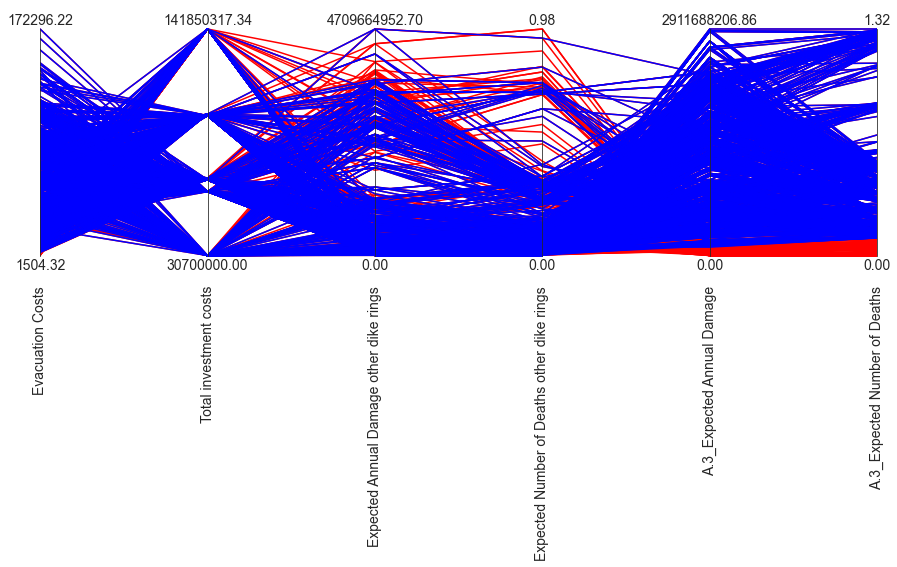

In [58]:
from ema_workbench.analysis import parcoords

# Scenarios where policies fail
data = pd.DataFrame({k:v[y] for k,v in outcomes.items()})
# All scenarios
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# Plot parcoords

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_data, color='red')
axes.plot(data, color='blue')
fig = axes.fig
fig.set_size_inches(15,5)
plt.show()

# Worst cases

In [59]:
print(all_data.idxmax())

Evacuation Costs                              853
Total investment costs                          0
Expected Annual Damage other dike rings       161
Expected Number of Deaths other dike rings    356
A.3_Expected Annual Damage                    236
A.3_Expected Number of Deaths                 785
dtype: int64


In [60]:
# Find the worst in data
worst_cases = data.iloc[list(data.idxmax())]
worst_cases

,Evacuation Costs,Total investment costs,Expected Annual Damage other dike rings,Expected Number of Deaths other dike rings,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
703,172296.224825,6.205801e+07,1.424576e+09,0.177277,1.454038e+09,0.389177
0,13375.865182,1.418503e+08,1.447637e+07,0.005395,5.610320e+08,0.369725
94,142238.819714,6.787643e+07,4.709665e+09,0.393944,2.311794e+09,0.453889
568,85677.971404,1.001322e+08,4.709665e+09,0.945465,2.311794e+09,1.089333
163,90628.755207,6.787643e+07,1.479792e+08,0.015658,2.911688e+09,0.549863
645,54590.497254,1.001322e+08,1.479792e+08,0.037580,2.911688e+09,1.319670


In [61]:
# Find the corresponding indeces for all_data
keys = list(worst_cases.columns.values)
i1 = all_data.set_index(keys).index
i2 = worst_cases.set_index(keys).index
worst_index = list(all_data[i1.isin(i2)].index)
worst_index

[1, 161, 236, 699, 785, 853]

In [62]:
# All we need are the uncertainty columns
selected = experiments.loc[worst_index, [o.name for o in dike_model.uncertainties]]
selected

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
1,2.5,2.5,3.5,34.0,232.567891,0.777911,10.0,160.775027,0.767903,1.5,146.946105,0.039300,10.0,97.632114,0.618062,1.0,211.548581,0.229185,1.5
161,2.5,1.5,1.5,24.0,210.837332,0.123387,10.0,183.036689,0.073788,1.5,138.902767,0.045564,1.5,180.817008,0.659529,1.0,212.799036,0.852287,10.0
236,1.5,1.5,1.5,33.0,133.480534,0.751003,1.0,228.854808,0.461140,10.0,50.782683,0.033239,1.0,247.353065,0.510307,1.5,222.798696,0.910786,1.0
699,2.5,1.5,1.5,24.0,210.837332,0.123387,10.0,183.036689,0.073788,1.5,138.902767,0.045564,1.5,180.817008,0.659529,1.0,212.799036,0.852287,10.0
785,1.5,1.5,1.5,33.0,133.480534,0.751003,1.0,228.854808,0.461140,10.0,50.782683,0.033239,1.0,247.353065,0.510307,1.5,222.798696,0.910786,1.0
853,4.5,4.5,3.5,75.0,160.026707,0.394881,1.5,70.506168,0.037045,1.0,284.831716,0.003802,10.0,223.176430,0.929999,1.5,289.447882,0.399382,1.0


# 236 and 785 are the same

In [63]:
# Drop 785
selected = selected.drop(785)
selected

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
1,2.5,2.5,3.5,34.0,232.567891,0.777911,10.0,160.775027,0.767903,1.5,146.946105,0.039300,10.0,97.632114,0.618062,1.0,211.548581,0.229185,1.5
161,2.5,1.5,1.5,24.0,210.837332,0.123387,10.0,183.036689,0.073788,1.5,138.902767,0.045564,1.5,180.817008,0.659529,1.0,212.799036,0.852287,10.0
236,1.5,1.5,1.5,33.0,133.480534,0.751003,1.0,228.854808,0.461140,10.0,50.782683,0.033239,1.0,247.353065,0.510307,1.5,222.798696,0.910786,1.0
699,2.5,1.5,1.5,24.0,210.837332,0.123387,10.0,183.036689,0.073788,1.5,138.902767,0.045564,1.5,180.817008,0.659529,1.0,212.799036,0.852287,10.0
853,4.5,4.5,3.5,75.0,160.026707,0.394881,1.5,70.506168,0.037045,1.0,284.831716,0.003802,10.0,223.176430,0.929999,1.5,289.447882,0.399382,1.0


In [64]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

Assignment 7 on hypervolume:

Sometimes it is known a priori. For example in the lake problem, reliability is scalled between 0 and 1. In contrast, the bounds on max_P are not known up front. To help with this, we can introduce a constraint saying that max_P must be below a particulare threshold.

In [10]:
convergence_metrics = [EpsilonProgress()]
nfe= 50000
# 30 grid cells in objective space per outcome
# Based on max values encountered in open exploration
epsilons = [1e5/30, 3.55e9/30, 5.45e9/30, 3.53/30, 2e9/30, 2.5/30]

ValueError: no expected_range is set for ['A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2']

In [ ]:
%%time

results_0_file = "results/results_0.csv"
convergence_0_file = "results/convergence_0.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_0 = pd.read_csv("results/results_0.csv")
    convergence_0 = pd.read_csv("results/convergence_0.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_0, convergence_0 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[0],
                                 epsilons=epsilons)
          
    results_0.to_csv("results/results_0.csv")
    convergence_0.to_csv("results/convergence_0.csv")

In [ ]:
fig, (ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence_0.nfe, convergence_0.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.show()

In [27]:
%%time

results_1_file = "results/results_1.csv"
convergence_1_file = "results/convergence_1.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_1 = pd.read_csv("results/results_1.csv")
    convergence_1 = pd.read_csv("results/convergence_1.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_1, convergence_1 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[1],
                                 epsilons=epsilons)
          
    results_1.to_csv("results/results_1.csv")
    convergence_1.to_csv("results/convergence_1.csv")

[MainProcess/INFO] generation 0: 0/1000 nfe


KeyboardInterrupt: 

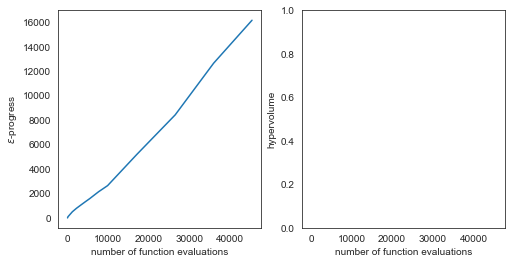

In [35]:
fig, (ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence_1.nfe, convergence_1.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.show()

In [15]:
%%time

results_1_file = "results/results_1.csv"
convergence_1_file = "results/convergence_1.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_1 = pd.read_csv("results/results_1.csv")
    convergence_1 = pd.read_csv("results/convergence_1.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_1, convergence_1 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[1],
                                 epsilons=epsilons)
          
    results_1.to_csv("results/results_1.csv")
    convergence_1.to_csv("results/convergence_1.csv")

[MainProcess/INFO] generation 0: 0/1000 nfe


KeyboardInterrupt: 

In [ ]:
%%time

results_2_file = "results/results_2.csv"
convergence_2_file = "results/convergence_2.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_2 = pd.read_csv("results/results_2.csv")
    convergence_2 = pd.read_csv("results/convergence_2.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_2, convergence_2 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[2],
                                 epsilons=epsilons)
          
    results_2.to_csv("results/results_2.csv")
    convergence_2.to_csv("results/convergence_2.csv")

In [ ]:
fig, (ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence_2.nfe, convergence_2.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
%%time

results_3_file = "results/results_3.csv"
convergence_3_file = "results/convergence_3.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_3 = pd.read_csv("results/results_3.csv")
    convergence_3 = pd.read_csv("results/convergence_3.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_3, convergence_3 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[3],
                                 epsilons=epsilons)
          
    results_3.to_csv("results/results_3.csv")
    convergence_3.to_csv("results/convergence_3.csv")

In [ ]:
fig, (ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence_3.nfe, convergence_3.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
%%time

results_4_file = "results/results_4.csv"
convergence_4_file = "results/convergence_4.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_4 = pd.read_csv("results/results_4.csv")
    convergence_4 = pd.read_csv("results/convergence_4.csv")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_4, convergence_4 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[4],
                                 epsilons=epsilons)
          
    results_4.to_csv("results/results_4.csv")
    convergence_4.to_csv("results/convergence_4.csv")

In [ ]:
fig, (ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence_4.nfe, convergence_4.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
results = pd.concat([results_0, results_1, results_2, results_3, results_4])

# Part 3

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.

In [24]:
result.loc[:,[o.name for o in dike_model.levers]]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,1,0,1,0,1,0,1,1,1,...,4,1,7,1,5,2,9,6,3,10
1,1,1,0,0,0,0,0,0,1,1,...,10,4,5,2,9,5,9,0,2,8
2,1,1,1,1,0,0,1,0,0,1,...,10,10,10,8,1,8,6,3,1,3
3,0,0,1,0,0,1,1,1,0,1,...,4,6,0,0,5,5,0,9,5,10
4,1,1,1,0,1,1,1,0,0,1,...,7,9,8,0,1,4,5,1,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0,1,0,1,1,0,0,1,1,1,...,6,6,9,0,4,5,4,7,0,5
79,0,1,0,1,1,0,0,0,0,0,...,5,1,10,9,9,3,10,1,9,9
80,1,0,0,1,1,0,1,1,0,0,...,3,2,4,0,3,5,0,3,6,6
81,1,1,1,1,0,1,0,1,0,1,...,2,9,2,1,5,2,8,4,8,4


In [25]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:,[o.name for o in dike_model.levers]]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [27]:
policies[0:10]

[Policy({'0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 1, '1_RfR 0': 1, '1_RfR 1': 1, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 7, 'A.1_DikeIncrease 1': 8, 'A.1_DikeIncrease 2': 10, 'A.2_DikeIncrease 0': 9, 'A.2_DikeIncrease 1': 7, 'A.2_DikeIncrease 2': 8, 'A.3_DikeIncrease 0': 1, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 1, 'A.4_DikeIncrease 0': 6, 'A.4_DikeIncrease 1': 3, 'A.4_DikeIncrease 2': 4, 'A.5_DikeIncrease 0': 1, 'A.5_DikeIncrease 1': 7, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 1, '0_RfR 1': 0, '0_RfR 2': 1, '1_RfR 0': 1, '1_RfR 1': 1, '1_RfR 2': 1, '2_RfR 0': 0, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 0, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 6, 'A.1_DikeIncrease 1': 3, 'A.1_DikeIncrease 2': 5, 'A.2_DikeIncrease 0': 2, 'A.2_DikeIncrease 1': 10, 'A.2_DikeInc

In [50]:
n_scenarios = 1000

In [29]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(n_scenarios, policies=policies[0:10])

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 10 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Domain Criterion

In [ ]:
thresholds = {'A.1_Expected Number of Deaths' : 0.01, 'A.2_Expected Number of Deaths' : 0.01, 'A.3_Expected Number of Deaths' : 0.01,
              'A.4_Expected Number of Deaths' : 0.01, 'A.5_Expected Number of Deaths' : 0.01, 'A.3_Dike Investment Costs' : 1e8, 
              "RfR Total Costs" : 1e8}

In [48]:
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,8.800418e+08,4.129222e+07,1.359014,0.000000e+00,3.604660e+07,0.000000,1.527666e+07,7.074086e+07,0.010490,8.916000e+08,0.0
1,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,1.024391e+08,4.129222e+07,0.180448,1.300055e+06,3.604660e+07,0.000508,1.009112e+07,7.074086e+07,0.006928,8.916000e+08,0.0
2,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,2.072457e+07,4.129222e+07,0.041257,0.000000e+00,3.604660e+07,0.000000,2.539863e+07,7.074086e+07,0.028671,8.916000e+08,0.0
3,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,2.308219e+08,4.129222e+07,0.586640,0.000000e+00,3.604660e+07,0.000000,0.000000e+00,7.074086e+07,0.000000,8.916000e+08,0.0
4,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,3.413713e+06,4.129222e+07,0.004685,0.000000e+00,3.604660e+07,0.000000,1.703720e+08,7.074086e+07,0.114495,8.916000e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,1.689989e+08,0.0,9.355763e+07,1.806918e+08,0.078631,0.000000e+00,9.782557e+07,0.000000,0.000000e+00,5.365900e+07,0.000000,0.000000e+00,1.229712e+08,0.000000,1.170600e+09,0.0
96,0.0,1.689989e+08,0.0,0.000000e+00,1.806918e+08,0.000000,0.000000e+00,9.782557e+07,0.000000,0.000000e+00,5.365900e+07,0.000000,7.415962e+07,1.229712e+08,0.085073,1.170600e+09,0.0
97,0.0,1.689989e+08,0.0,4.491567e+06,1.806918e+08,0.005248,7.414816e+06,9.782557e+07,0.016076,0.000000e+00,5.365900e+07,0.000000,0.000000e+00,1.229712e+08,0.000000,1.170600e+09,0.0
98,0.0,1.689989e+08,0.0,3.713628e+06,1.806918e+08,0.005335,0.000000e+00,9.782557e+07,0.000000,0.000000e+00,5.365900e+07,0.000000,0.000000e+00,1.229712e+08,0.000000,1.170600e+09,0.0


In [54]:
experiments, outcomes = reeevaluation_results

thresholds = {'A.1_Expected Number of Deaths' : 0.01, 'A.2_Expected Number of Deaths' : 0.01, 'A.3_Expected Number of Deaths' : 0.01,
              'A.4_Expected Number of Deaths' : 0.01, 'A.5_Expected Number of Deaths' : 0.01, 'A.3_Dike Investment Costs' : 1e8, 
              "RfR Total Costs" : 1e8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/n_scenarios 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [55]:
overall_scores

,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,RfR Total Costs
scenario 0 option 0,1.0,1.0,1.0,0.3,1.0,0.4,0.0
scenario 0 option 1,1.0,1.0,0.0,1.0,1.0,1.0,0.0
scenario 0 option 2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
scenario 0 option 3,1.0,1.0,1.0,0.9,1.0,0.9,0.0
scenario 0 option 4,1.0,1.0,1.0,0.6,0.8,1.0,0.0
scenario 0 option 5,1.0,0.8,0.0,1.0,1.0,1.0,0.0
scenario 0 option 6,1.0,1.0,1.0,0.9,1.0,0.8,0.0
scenario 0 option 7,1.0,0.6,0.0,1.0,0.9,0.9,0.0
scenario 0 option 8,1.0,1.0,1.0,1.0,1.0,0.9,0.0
scenario 0 option 9,1.0,0.7,1.0,0.6,1.0,0.9,0.0


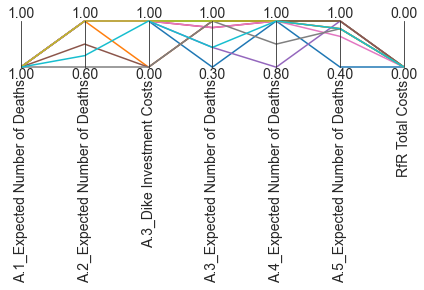

In [56]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
fig = paraxes.fig
fig.set_size_inches(15,5)
plt.show()

### Max Regret

In [58]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [64]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

    max_regret = pd.DataFrame(max_regret)

<ipython-input-64-f44384ddd3dc>:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


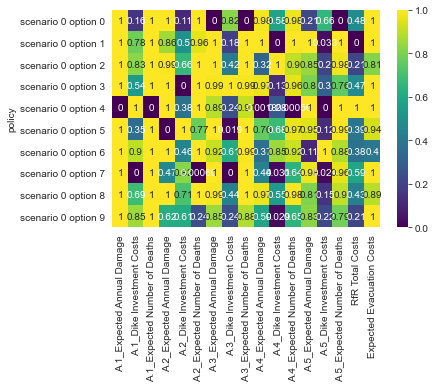

In [65]:
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

C:\Users\archipel-03\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\archipel-03\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:261: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


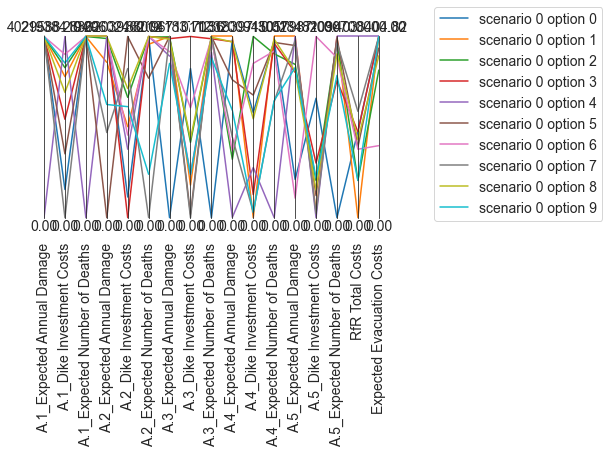

In [67]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
fig = paraxes.fig
fig.set_size_inches(15,5)    
plt.show()

From model answers assignment 8:

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it

In [69]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

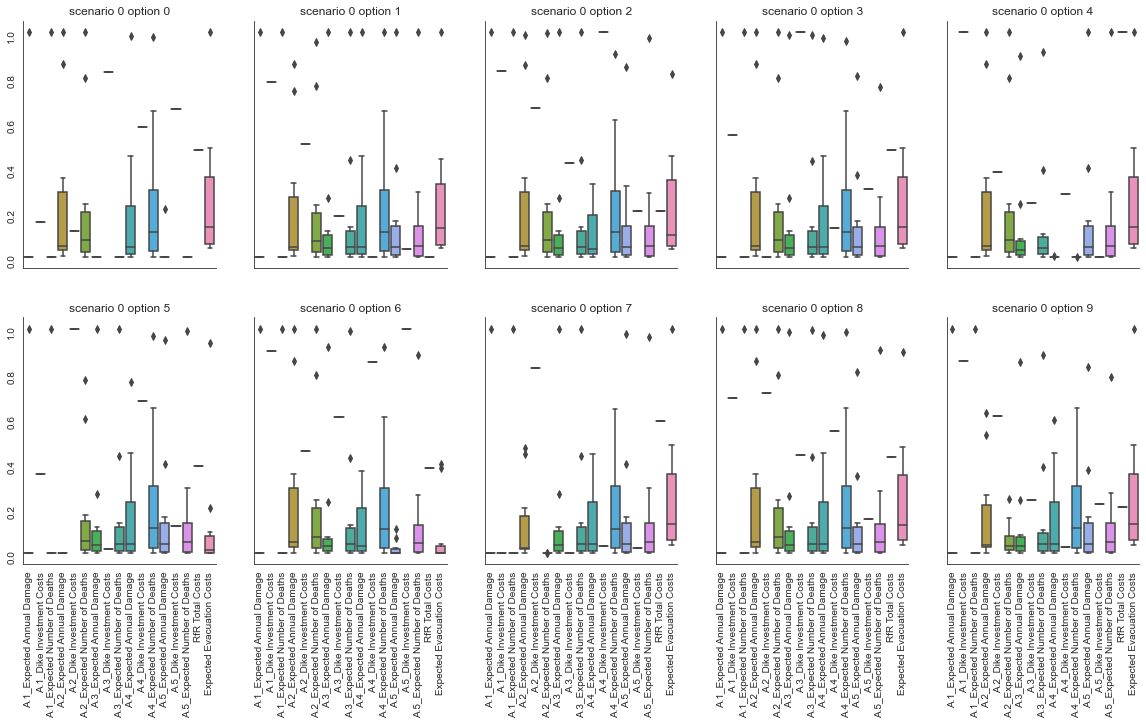

In [79]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are ten plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4],
        axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    ax.tick_params(labelrotation=90)
    #plt.xticks(rotation=90)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    


plt.show()